In [2]:
# Test the tool on single-cell rnaseq data from bone marrow 

In [3]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

In [4]:
data_importer = flexynesis.DataImporter(path ='/data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/', 
                                        data_types = ['RNA', 'ADT'], 
                                        concatenate=False, top_percentile=1, min_features=25)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/train/RNA.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/train/ADT.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/train/clin.csv...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/test/RNA.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/test/ADT.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/test/clin.csv...

[INFO] ---------- Processing Data (tr

Filtering redundant features: 100%|██████████| 1835/1835 [00:04<00:00, 416.29it/s]


Implementing feature selection using laplacian score for layer: ADT with  25 features
Returning original matrix, demanded # of features is  larger than existing number of features

[INFO] ---------- Processing Data (test) ----------

[INFO] --------------- Cleaning Up Data ---------------
Number of NA values:  0
[INFO] DataFrame RNA - Removed 316 features.
Number of NA values:  0
[INFO] DataFrame ADT - Removed 0 features.
DataFrame RNA - Removed 0 samples (0.00%).
DataFrame ADT - Removed 0 samples (0.00%).

[INFO] ------------ Harmonizing Data Sets ------------

[INFO] --------------- Normalizing Data ---------------

[INFO] --------------- Normalizing Data ---------------
[INFO] Training Data Stats:
 {'feature_count in: RNA': 165, 'feature_count in: ADT': 25, 'sample_count': 5000}
[INFO] Test Data Stats:
 {'feature_count in: RNA': 165, 'feature_count in: ADT': 25, 'sample_count': 5000}
[INFO] Data import successful.


In [5]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: nCount_RNA
Numerical Variable Summary: Median = 2280.0, Mean = 2927.5772
------
Summary for variable: nFeature_RNA
Numerical Variable Summary: Median = 762.0, Mean = 883.229
------
Summary for variable: nCount_ADT
Numerical Variable Summary: Median = 4449.5, Mean = 4545.3088
------
Summary for variable: nFeature_ADT
Numerical Variable Summary: Median = 25.0, Mean = 24.8738
------
Summary for variable: RNA_weight
Numerical Variable Summary: Median = 0.405137738168857, Mean = 0.39226083495690867
------
Summary for variable: orig_ident
Categorical Variable Summary:
  Label: bmcite, Count: 5000
------
Summary for variable: lane
Categorical Variable Summary:
  Label: HumanHTO1, Count: 466
  Label: HumanHTO10, Count: 466
  Label: HumanHTO2, Count: 505
  Label: HumanHTO3, Count: 523
  Label: HumanHTO4, Count: 381
  Label: HumanHTO5, Count: 508
  Label: HumanHTO6, Count: 523
  Label: HumanHTO7, Count: 596
  Label: HumanHTO8, Count: 545
  Label: HumanHTO9, Count: 487
-----

In [6]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "celltype_l2",
                                        config_name = "DirectPred", 
                                        config_path='./conf.yaml',
                                        plot_losses=True, early_stop_patience=20, 
                                        n_iter=20)    

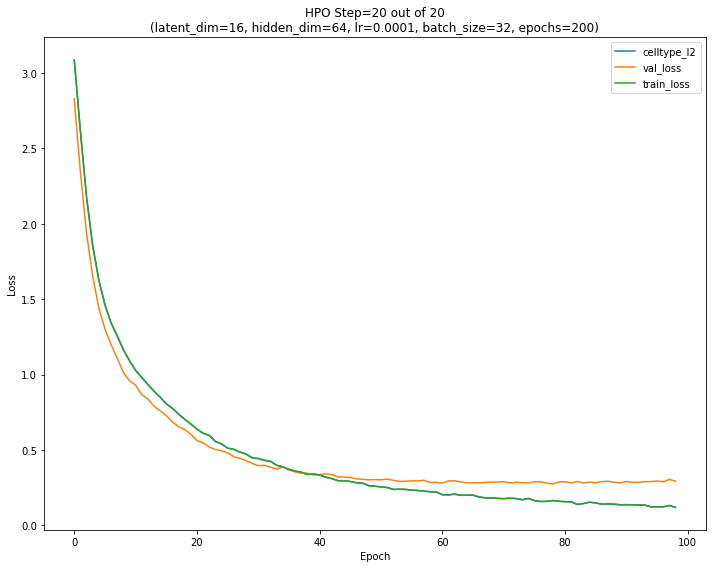

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.275. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        celltype_l2        │    0.29215213656425476    │
│         val_loss          │    0.29215213656425476    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 20/20 [33:26<00:00, 100.30s/it, Iteration=20, Best Loss=0.281]


In [7]:
model, best_params = tuner.perform_tuning()

In [8]:
model

DirectPred(
  (log_vars): ParameterDict(  (celltype_l2): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=165, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=25, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (celltype_l2): MLP(
      (layer_1): Linear(in_features=128, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=27, bias=True)
      (relu): ReLU()
   

In [9]:
best_params

{'latent_dim': 64,
 'hidden_dim': 64,
 'lr': 0.0001,
 'batch_size': 32,
 'epochs': 200}

In [10]:
y_pred_dict = model.predict(test_dataset)

In [11]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,celltype_l2,categorical,balanced_acc,0.762163
1,celltype_l2,categorical,f1_score,0.785070
2,celltype_l2,categorical,kappa,0.899711


In [12]:
ds = test_dataset
E = model.transform(ds)

In [13]:
f = 'celltype_l2'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

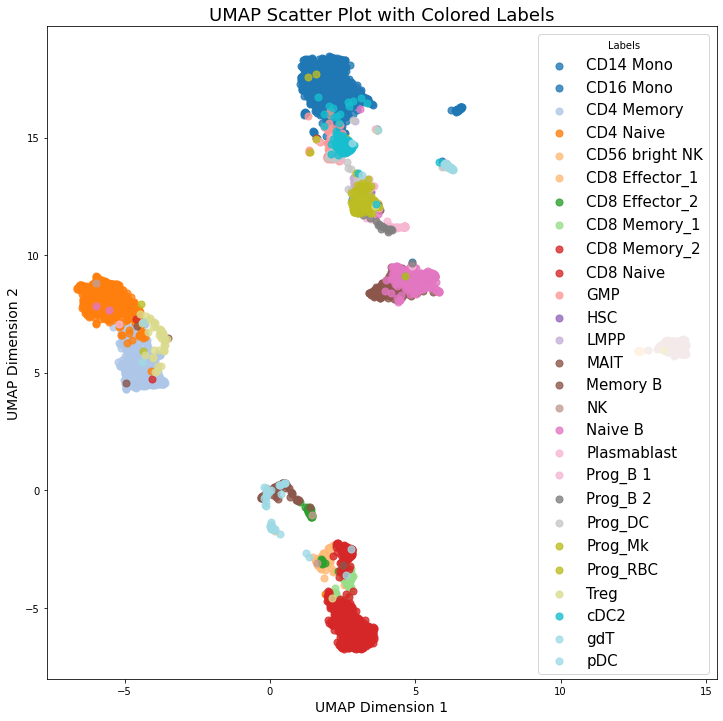

In [14]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':50, 'alpha': 0.8},legend_kwargs={'fontsize': 15}, figsize=(12, 12))

In [15]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 1)

In [16]:
top_features = flexynesis.get_important_features(model, f, top=2)

In [17]:
my_dict = train_dataset.label_mappings['celltype_l2']
my_list = top_features['target_class']
top_features['target_class_label'] = [my_dict.get(item) for item in my_list if item in my_dict]
top_features

,target_variable,target_class,layer,name,importance,target_class_label
0,celltype_l2,0,ADT,CD14,2.344063,CD14 Mono
1,celltype_l2,0,ADT,CD11c,0.963984,CD14 Mono
2,celltype_l2,1,ADT,CD16,0.672414,CD16 Mono
3,celltype_l2,1,ADT,CD11a,0.667823,CD16 Mono
4,celltype_l2,2,ADT,CD45RA,1.271699,CD4 Memory
5,celltype_l2,2,ADT,CD4,1.135317,CD4 Memory
6,celltype_l2,3,ADT,CD4,1.737813,CD4 Naive
7,celltype_l2,3,ADT,CD8a,1.302721,CD4 Naive
8,celltype_l2,4,ADT,HLA.DR,0.454598,CD56 bright NK
9,celltype_l2,4,ADT,CD14,0.426339,CD56 bright NK


In [18]:
list(top_features[top_features['target_class']==4]['name'])

['HLA.DR', 'CD14']

In [19]:
train_dataset.label_mappings['celltype_l1']

{0: 'B cell', 1: 'Mono/DC', 2: 'NK', 3: 'Progenitor cells', 4: 'T cell'}

In [20]:
import numpy as np 
tf = top_features.groupby('layer')['name'].apply(list).to_dict()
tf = {x: np.unique(tf[x]) for x in tf.keys()} # get unique sets per layer

In [21]:
df = flexynesis.subset_assays_by_features(ds, tf)

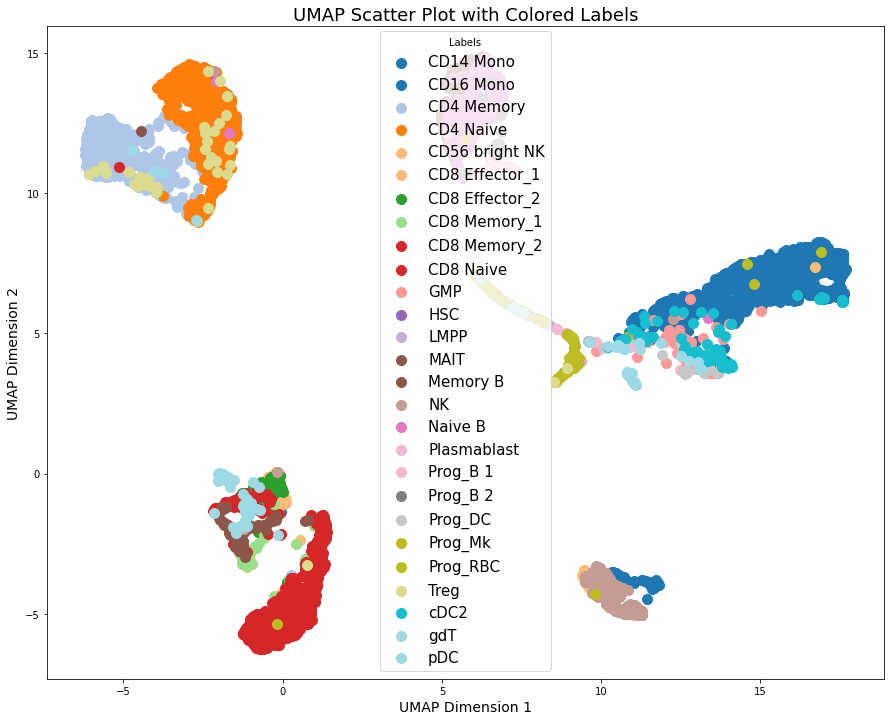

In [22]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':100}, legend_kwargs={'fontsize': 15}, figsize=(15, 12))